In [221]:
import csv

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42

# Specify each path

In [222]:
dataset = 'model/keypoint_classifier/keypoint.csv'
model_save_path = 'model/keypoint_classifier/keypoint_classifier.hdf5'
tflite_save_path = 'model/keypoint_classifier/keypoint_classifier.tflite'

# Set number of classes

In [223]:
NUM_CLASSES = 27

# Dataset reading

In [224]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))

In [225]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

In [226]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

# Model building

In [227]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((21 * 2, )),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [228]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout_20 (Dropout)         (None, 42)                0         
_________________________________________________________________
dense_30 (Dense)             (None, 20)                860       
_________________________________________________________________
dropout_21 (Dropout)         (None, 20)                0         
_________________________________________________________________
dense_31 (Dense)             (None, 10)                210       
_________________________________________________________________
dense_32 (Dense)             (None, 27)                297       
Total params: 1,367
Trainable params: 1,367
Non-trainable params: 0
_________________________________________________________________


In [229]:
# Model checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# Callback for early stopping
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

In [230]:
# Model compilation
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Model training

In [231]:
model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/1000
81/93 [=========================>....] - ETA: 0s - loss: 3.2169 - accuracy: 0.1087
Epoch 00001: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
93/93 [==============================] - 0s 2ms/step - loss: 3.2018 - accuracy: 0.1143 - val_loss: 3.0330 - val_accuracy: 0.1793
Epoch 2/1000
87/93 [===========================>..] - ETA: 0s - loss: 2.9701 - accuracy: 0.1558
Epoch 00002: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
93/93 [==============================] - 0s 2ms/step - loss: 2.9624 - accuracy: 0.1558 - val_loss: 2.7322 - val_accuracy: 0.1968
Epoch 3/1000
50/93 [===============>..............] - ETA: 0s - loss: 2.7939 - accuracy: 0.1734
Epoch 00003: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
93/93 [==============================] - 0s 1ms/step - loss: 2.7438 - accuracy: 0.1811 - val_loss: 2.4748 - val_accuracy: 0.2601
Epoch 4/1000
48/93 [==============>...............] - ETA: 0s - loss: 2.6219 - accura

In [232]:
# Model evaluation
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=128)

31/31 [==============================] - 0s 549us/step - loss: 1.0255 - accuracy: 0.7753


In [233]:
# Loading the saved model
model = tf.keras.models.load_model(model_save_path)

In [234]:
# Inference test
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

[2.83854053e-04 4.94953711e-05 3.03725693e-02 4.61467949e-04
 6.40261732e-03 3.37800290e-03 6.34328835e-03 1.71061640e-03
 4.46698454e-04 1.78901115e-04 5.32758313e-05 3.06427218e-02
 1.85879215e-03 1.62083132e-04 6.05728856e-05 2.97090359e-04
 7.10188324e-05 1.03880062e-04 2.71721989e-01 9.53098875e-04
 6.34054537e-04 2.75744796e-01 2.71518052e-01 8.11694115e-02
 9.33105242e-04 1.67662779e-06 1.44468425e-02]
21


# Confusion matrix

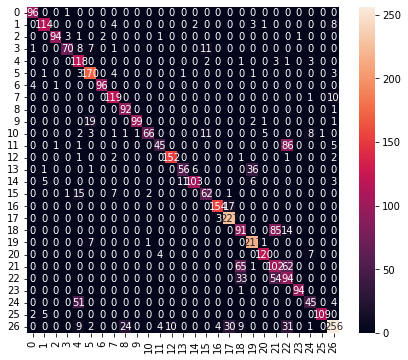

Classification Report
              precision    recall  f1-score   support

           0       0.93      0.99      0.96        97
           1       0.90      0.86      0.88       132
           2       0.98      0.92      0.95       102
           3       0.93      0.71      0.81        98
           4       0.56      0.92      0.70       128
           5       0.81      0.93      0.87       183
           6       0.98      0.95      0.96       101
           7       0.86      0.92      0.89       130
           8       0.79      0.99      0.88        93
           9       0.99      0.81      0.89       122
          10       0.96      0.67      0.79        99
          11       0.83      0.33      0.47       138
          12       0.94      0.96      0.95       159
          13       0.82      0.56      0.67       100
          14       0.93      0.80      0.86       128
          15       0.72      0.70      0.71        88
          16       0.96      0.90      0.93       171
     

In [235]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

# Convert to model for Tensorflow-Lite

In [236]:
# Save as a model dedicated to inference
model.save(model_save_path, include_optimizer=False)

In [237]:
# Transform model (quantization)

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: C:\Users\WONGCH~1\AppData\Local\Temp\tmp0k_ehysj\assets


INFO:tensorflow:Assets written to: C:\Users\WONGCH~1\AppData\Local\Temp\tmp0k_ehysj\assets


7344

# Inference test

In [238]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

In [239]:
# Get I / O tensor
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [240]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [241]:
%%time
# Inference implementation
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

Wall time: 0 ns


In [242]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[2.8385388e-04 4.9495338e-05 3.0372564e-02 4.6146769e-04 6.4026141e-03
 3.3780006e-03 6.3432856e-03 1.7106152e-03 4.4669860e-04 1.7890100e-04
 5.3275799e-05 3.0642718e-02 1.8587927e-03 1.6208310e-04 6.0572904e-05
 2.9709045e-04 7.1018854e-05 1.0388009e-04 2.7172193e-01 9.5309876e-04
 6.3405407e-04 2.7574489e-01 2.7151808e-01 8.1169434e-02 9.3310460e-04
 1.6766252e-06 1.4446844e-02]
21
